# **Task 3: Modify the network**

This time, we use `mobilenetV2` instead of `res50` as our backbone model. We will use mostly the same code except for when we use a different pre-trained model.




In [1]:
#clone git respositories containing helper functions
!git clone https://github.com/pytorch/vision.git
#append the created directory so that modules can be imported directly
import sys
sys.path.append("/content/vision/references/detection")

data = "/content/drive/My Drive/PennFudanPed"

Cloning into 'vision'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9780 (delta 2), reused 1 (delta 0), pack-reused 9777
Receiving objects: 100% (9780/9780), 11.48 MiB | 22.78 MiB/s, done.
Resolving deltas: 100% (6803/6803), done.


In [2]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Instead of the `get_instance_segmentation_model` function, we now use `modification_model` to instantiate our model instead.

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import MaskRCNN
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def modification_model(num_classes):
 
    # load a pre-trained model for classification and return
    # only the features
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    # MaskRCNN needs to know the number of
    # output channels in a backbone. For mobilenet_v2, it's 1280
    # so we need to add it here
    backbone.out_channels = 1280


    
    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios 
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                      aspect_ratios=((0.5, 1.0, 2.0),))
    
    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    

    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                              output_size=14,
                                                              sampling_ratio=2)
    # put the pieces together inside a FasterRCNN model
    model = MaskRCNN(backbone,
                      num_classes=2,
                      rpn_anchor_generator=anchor_generator,
                      box_roi_pool=roi_pooler,
                      mask_roi_pool=mask_roi_pooler)
    return model

In [4]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts PIL image to PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
# load dataset
dataset = PennFudanDataset(data, get_transform(train=True))
dataset_test = PennFudanDataset(data, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

We also choose to use Adam optimizer instead now. Adam is a widely used optimizer in neural network trainings as it can automatically update its learning rate as the training progresses and thus it can quickly determine a reasonable learning rate by itself.

In [6]:
# use gpu when avaliable
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
# get the model using our helper function
model = modification_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005,
 #                           momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params,lr = 0.001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


We train for 40 epochs this time as it takes a much longer time for our model to reach a satisfactory result.

After 40 epochs , we see that bbox IoU 0.5:0.95 reaches 0.647 and segm IoU 0.5:0.95 reaches 0.577 which is quite a deprovement from our previous model with the `resnet50`.

Even though each epoch takes a shorter time due to the smaller artitecture of `mobilenet-v2`, it is not able to reach a high accuracy in our case.

Furthemore, due to how our dataset is small, of only 100 images, the time difference per epouch is also negligible.

In [ ]:
num_epochs = 40
#mobilenet , while it trained much faster , it only reach a 0.414 acc after 10 epochs
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model.state_dict(), '/content/drive/My Drive/'+ 'Penn.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/60]  eta: 0:01:12  lr: 0.000018  loss: 0.2288 (0.2288)  loss_classifier: 0.0168 (0.0168)  loss_box_reg: 0.0393 (0.0393)  loss_mask: 0.1675 (0.1675)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 1.2095  data: 0.6584  max mem: 6847
Epoch: [0]  [10/60]  eta: 0:00:25  lr: 0.000187  loss: 0.2242 (0.2209)  loss_classifier: 0.0201 (0.0212)  loss_box_reg: 0.0427 (0.0440)  loss_mask: 0.1517 (0.1428)  loss_objectness: 0.0041 (0.0049)  loss_rpn_box_reg: 0.0078 (0.0079)  time: 0.5032  data: 0.0636  max mem: 6847
Epoch: [0]  [20/60]  eta: 0:00:18  lr: 0.000357  loss: 0.1980 (0.2095)  loss_classifier: 0.0201 (0.0212)  loss_box_reg: 0.0317 (0.0411)  loss_mask: 0.1207 (0.1351)  loss_objectness: 0.0031 (0.0044)  loss_rpn_box_reg: 0.0078 (0.0077)  time: 0.4368  data: 0.0054  max mem: 6847
Epoch: [0]  [30/60]  eta: 0:00:13  lr: 0.000526  loss: 0.1741 (0.1990)  loss_classifier: 0.0188 (0.0204)  loss_box_reg: 0.0260 (0.0378)  loss_mask: 0.1163 (0.1294)  loss_ob

In [22]:
img, _ = dataset_test[15]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device).cpu()])

This is the image we are testing our model on.

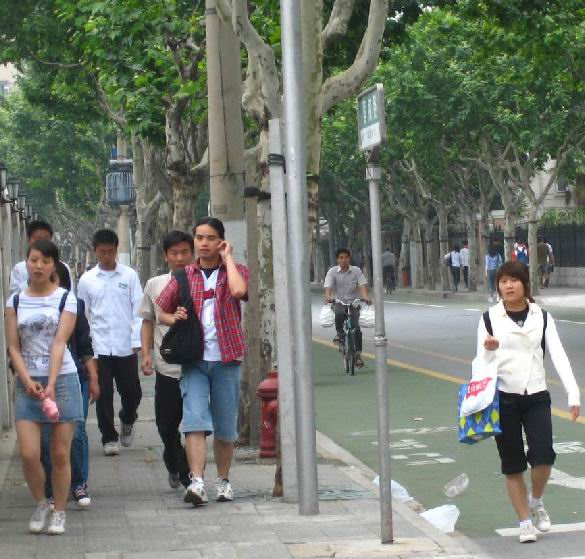

In [23]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [11]:
import random
def random_colour_masks(image):
 
        colours = [[0, 0, 255],[0, 255, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190    , 190]]
        r = np.zeros_like(image).astype(np.uint8)
        g = np.zeros_like(image).astype(np.uint8)
        b = np.zeros_like(image).astype(np.uint8)
        r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
        coloured_mask = np.stack([r, g, b], axis=2)
        return coloured_mask

Compared to previously, our new model is performing much worse. Compared to previously, it is unable to detect the red checkered shirt guy, but instead detected the guy behind him instaed.

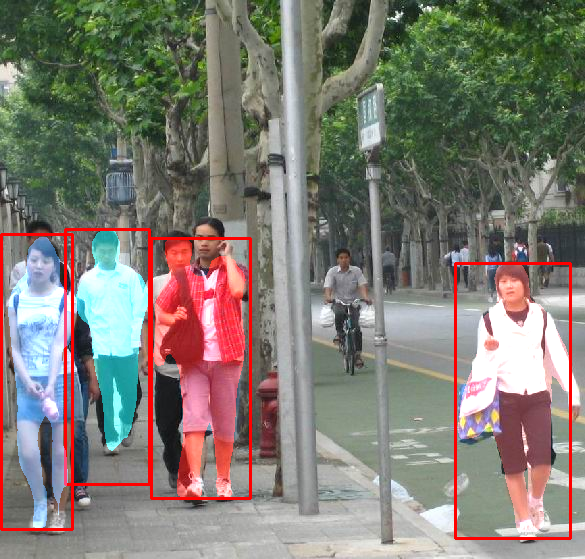

In [24]:
import cv2
from google.colab.patches import cv2_imshow

from torchvision import transforms

noOfMasks = sum(prediction[0]['scores']>0.8).item()
to_pil = transforms.ToPILImage()
IMAGE = to_pil(img)
img_cv = cv2.cvtColor(np.array(IMAGE), cv2.COLOR_RGB2BGR)
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(prediction[0]['boxes'].cpu().detach().numpy())]
masks = (prediction[0]['masks']>0.5).squeeze().detach().cpu().numpy()
for i in range(noOfMasks):
    # iterate over masks
    rgb_mask = random_colour_masks(masks[i])
    img_cv = cv2.addWeighted(img_cv,1,rgb_mask,0.5,0)
    cv2.rectangle(img_cv,pred_boxes[i][0],pred_boxes[i][1],color    =(0,0,255),thickness = 2)

cv2_imshow(img_cv)